In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np

# 12.3. 사용자 정의 모델과 훈련 알고리즘

### 12.3.1. 사용자 정의 손실함수
- MSE와 MAE에 오버피팅등의 문제, 이상치의 문제 등이 있을 떄, 사용할 수 있는 대표적인 손실함수는 Huber가 있은아, 공식 케라스 API 지원하지 않음. 아래와 같이 구현 가능

In [2]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, square_loss, linear_loss)

- NN에서 tf를 이용하여 모델을 구성할 떄는 되도록 위 예시처럼 모든 과정을 벡터화해야하며, tf 연산만 활용해야함

In [3]:
# model.compile(loss = huber_fn, optimizer = "namdam")
# model.fit(X_tr, y_tr, ...)

- 그런데 이렇게 임의로 지정한 함수는 모델을 저장할 때 문제가됨

### 12.3.2. 사용자 정의 요소를 가진 모델의 저장/로드
- 저장시에는 케라스가 함수 이름을 저장하므로, 사실 별 문제가 안됨
- 다만, 모델을 로딩할 때 함수 이름과 실제 함수를 매핑할 딕셔너리를 전달해야함

In [4]:
# model = keras.models.load_model("model.h5", custom_object = {"huber_fn" : huber_fn})
# # 따로 loss가 이거다, 저거다를 정의하지 않아도 되며, 이름만 일치하면 됨

In [5]:
def create_huber(thr = 1.0): # 에러가 큰 지 작은 지 판단할 수 있는 threshold를 인자로 받는 생성함수를 만들어주기
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < thr
        squared_loss = tf.square(error) / 2
        linear_loss = thr * tf.abs(error) - thr*2*0.5
        return tf.where(is_small_error, square_loss, linear_loss)
    return huber_fn

# model.compile(loss = create_huber(2.0), optimizer = "nadam")

- 위 threshold는 모델 저장시에 저장되지 않으며, 모델 로드시 threshold값을 지정하여 dic 전달 필요

In [6]:
# model = keras.models.load_model("model.h5", custom_objects = {"huber_fn" : create_huber(2.0)})

- 이렇게 threshold를 지정하는 과정이 귀찮다면, 처음 loss function을 정의할 때 keras.losses.Loss 클래스를 상속하고 get_config()를 구현하는 방식이 있음

In [7]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold = 1.0, **kwargs): # 기본적인 하이퍼파라미터를 **Kwargs로 받은 인자를 부모 클래스 생성자에 전달
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred): # 모든 샘플의 손실을 계산하여 반환
        error = y_true - y_pred
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold*2*0.5
        return tf.where(is_small_error, square_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold" : self.threshold} # 하이퍼파라미터 이름과 같이 매핑된 딕셔너리를 반환

- 위 처럼 클래스를 선언하면, 컴파일 시 이 클래스의 인스턴스를 그대로 이용할 수 있음

In [8]:
# model.compile(loss = HuberLoss(2.), optimizer = "nadam")

- 이렇게 컴파일한 모델을 저장하면 threshold도 함께 저장됨. 처음처럼 클래스 이름과 클래스 자체만 매핑해주면 됨
- 여기서는 선언한 함수의 이름이 아니라 '클래스'명 자체를 매치시켜줘야함

In [9]:
# model = keras.model.load_model("model.h5", custom_objects = {"HuberLoss" : HuberLoss})

### 12.3.3. 활성화 함수, 초기화, 규제, 제한 커스터마이징
- 위와 비슷한 방식으로 커스터마이징 가능

In [10]:
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype = tf.float32):
    stddev = tf.sqrt(2. / (shape[0]) + shape[1])
    return tf.random.normal(shape, stddev = stddev, dtype = dtype)

def my_l1_reguralizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeors_like(weights), weights)

- 만약 함수가 모델과 함께 저장해야할 하이퍼파라메터를 가지고 있다면, 적절한 클래스를 상속해야함
    - ex : keras.regularizers.Regularizer, keras.constraints.Constraint, keras.initializers.Initializer, keras.layers.Layer 등
- 예를들어 factor 하이퍼파라미터를 저장하는 l1규제를 클래스로 선언해보면 아래와 같음

In [11]:
# Regularizer 공식 문서를 참고해야함
# 얘의 경우 부모 클래스에 생성자와 get_config()메서드가 정의되어있지 않음
# 따라서 **kwargs를 호출하지 않았으며, get_config과정에서 **base_config를 받아오지 않아도 됨

class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor" : self.factor}

- call()구현 대상 : 손실, 층, 모델
- \_\_call__() 구현 대상 : 규제, 초기화 제한

### 12.3.4. 사용자 정의 지표
- 지표와 손실의 기본적인 개념은 거의 동일하다고 봐도 됨
    - 다만, 지표의 경우 모든 지점에서 0이어도 되며, 미분이 불가능한 지점이 있어도 됨
    - 또한, 지표는 우리가 모델의 결과를 해석하기 위해 존재하는 것이므로, 사람이 이해할 수 있어야함

- 훈련 중에 케라스는 모델의 지표를 기록하고, 모든 에포크에서 나온 결과를 평균내서 보여줌
    - 근데, 이것이 문제가 있음. 예를 들어 다음과 같은 결과가 있다고 가정

In [12]:
precision = keras.metrics.Precision()

print(precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]))
print(precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0]))

tf.Tensor(0.8, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)


- 실제 모델로 만들어서 에포크별로 위와 같은 결과를 뱉었다면, 정밀도는 40%로 평균을 얻을 수 있음
    - 그러나, 각각은 80%, 0%라지만, 실제로는 전체 8개의 TP+FP중 4개가 TP
        - 즉, 실제 정밀도는 50%인 것
- 모델별로 업데이트 되는 정밀도를 기록하기 위한 것을 스트리밍 지표라고 부름(streaming metric or stateful metric)

In [13]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [14]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [15]:
precision.reset_states() # 계속 점진적으로 업데이트 되는 것을 0으로 리셋

- 스트리밍 지표를 만드려면 keras.metrics.Metric클래스를 상속

In [17]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold = 1.0, **kwargs): # **base_config를 호출해야 하는 애들은 **kwargs를 추가
        super().__init__(**kwargs) #기본 매개변수 처리 ex : dtype
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer = "zeros") # 여러 배치에 걸쳐 지표의 상태를 기록하기 위한 변수를 생성
        self.count = self.add_weight("count", initializer = "zeros")
    def update_state(self, y_true, y_pred, sample_weight = None): # 이 클래스를 함수처럼 이용할 때 호출됨.(생성자 바로 다음에 있으니까)
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric)) #값 자체를 바꿔줘야하므로, tf.Variable의 값을 바꿀 수 있는 assign_add메서드 이용
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32)) # tf.size(y_true)가 정수형이므로 cast로 float32로 수정
    def result(self):
        return self.total/self.count
    def get_config(self): # get_config메서드를 구현하여 threshold 변수를 모델과 함께 저장
        base_config = super().get_config()
        return {**base_config, "threshold" : self.threshold}

### 12.3.5. 사용자 정의 층
- 가끔, 특이한 층을 가진 네트워크를 만들어야할때가 있음
    - 또한, 동일한 층 블럭이 여러 번 반복되는 네트워크를 만들 때는 각각을 하나의 층으로 다루는 것이 편리함

##### 가중치가 필요없는 층
- keras.layesr.Flatten이나 keras.layesr.ReLU와 같은 층은 가중치가 없음
- 이런 애들은 그냥 함수를 만들어서 Labmda층으로 감싸는 방법을 선택할 수 있음

In [18]:
# 입력에 지수함수를 적용하는 층의 적용
exponential_layer = keras.layers.Lambda(lambda x : tf.exp(x)) # 마치 pandas에 apply lambda를 쓰듯

- 위 처럼 만든 층은 시퀀셜 API나 함수형 API, 서브클래싱 API에서 일반적인 층처럼 이용할 수도 있으며, 활성화 함수로 이용할 수도 있음

##### 가중치가 필요한 층(상태가 있는 층)
- keras.layers.Layer를 상속해야함

In [19]:
# Dense의 간소화된 버전
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        
    def build(self, batch_input_shape): # 가중치마다 add_weight()메서드를 호출하여 층으 ㅣ변수를 만드는 것으로, 층이 처음 사용될 때 호출됨
        self.kernel = self.add_weight(
            name = "kernel", shape = [batch_input_shape[-1], self.units],
            initializer = "glorot_normal")
        self.bias = self.add_weight(
            name = "bias", shape = [self.units], initializer = "zeros")
        super().build(batch_input_shape) # 그리고, 마지막에 반드시 부모의 build()메서드를 호출해야하므로 super로 부모의 build를 불러옴
                      
    def call(self, X):
        return self.activation(X @ self.kernel + self.bias) # 이 층에 필요한 연산을 수행함
            
    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units]) # 이 층의 출력 크기를 반환
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units" : self.units,
               "activation" : keras.activations.serialize(self.activation)}

##### 여러 입력을 받는 층
- concatenate와 같은 층을 만드려면 call() 메서드에 모든 입력이 포함된 튜플을 매개변수로 전달해야하며, compute_output_shape() 메서드의 매개변수도 각 입력의 배치 크기르 담은 튜플이어야함

##### 여러 출력을 반환하는 층
- call()메서드가 출력의 리스트를 반환해야하며, compute_output_shape()메서드는 출력마다 하나씩 배치 출력 크기의 리스트를 반환해야함

In [20]:
# 두 개의 입력과 세 개의 출력을 만드는 층

class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X # 튜플 형태로 들어온 X값을 X1, X2에 분배
        return [X1 + X2, X1 * X2, X1 / X2] #세 개의 값을 반환
    
    def compute_output_shape(self, batch_input_shape):
        b1, b2 = batch_input_shape
        return [b1, b1, b1] # 세 개의 값을 브로드캐스팅

##### 훈련과 테스트에서 다르게 동작하는 층
- Dropout이나 BatchNormalization과 같이 훈련과 테스트에서 다르게 동작하는 층이 필요하다면 call()메서드에 training인자를 추가하여 훈련인지 테스트인지 결정

In [21]:
# 훈련 중에 가우시안 잡음을 추가하고 테스트 시에는 아무것도 하지 않는 층

class MyGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev
        
    def call(self, X, trianing = None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev = self.stddev)
            return X + noise
    
    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

### 12.3.6. 사용자 정의 모델
- 자세한 설명은 일단 생략하고, 코드만 확인

In [22]:
class ResidualBlock(keras.layers.Layer): # 층 구현
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation = "elu", kernel_initializer = "he_normal") for _ in range(n_layers)]
        
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [23]:
class ResidualRegressor(keras.Model): # 서브 클래스 API로 모델 정의
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation = "elu", kernel_initializer = "he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)
        
    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

- Model 클래스는 Layer 클래스의 서브 클래스이므로 모델을 층처럼 정의할 수 있음
    - 하지만 Model 클래스는 compile, fit, evaluate, predict, get_layers, save 메서드가 있음

### 12.3.7. 모델 구성 요소에 기반한 손실 및 지표
- 지금까지 정의한 사용자 손실과 지표는 모두 레이블과 예측을 기반으로 하지만, 때떄로 "은닉층"의 가중치나 활성화 함수 등과 같이 모델의 구성 요소에 기반한 손실을 정의해야함
    - 모델 내부 상황을 모니터링할 떄 유용
- 최상단 은닉층에 보조출력을 가지는 MLP모델을 테스트
    - 보조출력에 연결된 손실을 재구성 손실이라고 하며(재구성과 입력 사이의 평균 제곱 오차라고 함), 결과에 큰 영향을 주지는 않지만 정보량을 유지하게 해주며, 이따금 일반화 성능을 향상시키기도 함

In [2]:
class ReconstructingRegressor(keras.Model):
    def __init__(self, output_dim, **kwargs): # 생성자에서 5개의 은닉층과 하나의 출력층으로 이루어진 심층신경망 구성
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation = "selu", kernel_initializer = "lecun_normal")
                      for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        
    def build(self, batch_input_shape): # 생성자에서 이미 만들어진 모델에 재구성을 위한 완전연결층 추가
        n_inputs = batch_input_shape[-1] # 이 완전연결층의 유닛 수는 입력 개수와 같아야함
        self.reconstruct = keras.layers.Dense(n_inputs) 
        super().build(batch_input_shape)
        
    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z) # __init__에서 선언된 다섯개의 층을 모두 지남
        reconstruction = self.reconstruct(Z) # 재구성 값 생성
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs)) # 재구성 손실 생성
        self.add_loss(0.05 * recon_loss) # 재구성 손실 추가
        return self.out(Z) # 마지막으로 출력을 출력층에 전달하여 얻은 출력값 반환

- 이와 비슷하게 모델의 구성요소에 기반한 임의의 계산을 수행하는 사용자 정의 지표를 추가할 수 있음
    - 다만 결과값이 지표 객체의 출력이어야 함
        - ex : kears.metrics.Mean()객체를 만들고 recon_loss를 전달하며 call()메서드를 호출
    - add_metric 메서드를 호출하여 모델에 이 지표를 추가
- 위와같이 진행하면 모델 훈련시 에포크마다 평균 손실과 평균 재구성 손실을 출력함
    - 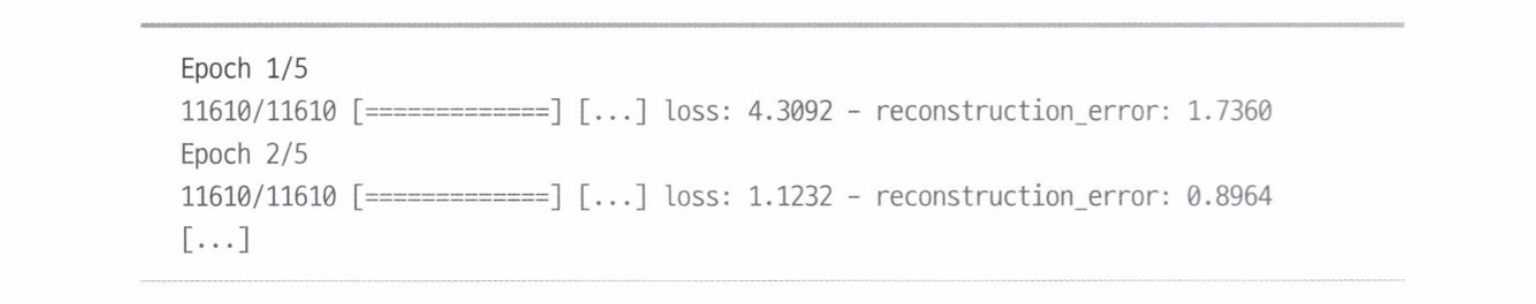

### 12.3.8. 자동 미분과 그래디언트 계산
- 다항함수에 대해 도함수를 구하는 것 자체는 그렇게 어려운 일은 아닐 수 있음
- 그러나, DNN에서는 파라메터도 쥰내 많고 구해야할 값도 쥰내 많음
- 매번 이걸 다 구하는 것도 에바참치니까 파라미터가 바뀔 떄 마다 함수의 출력이 얼마나 변하는 지 측정하면 도함수의 근사값을 계산할 수 있음
    - 매우 작은 값 epsilon만큼 x값이 바뀔 떄 y값이 얼마나 변하는지 체크체크

In [2]:
def f(w1, w2):
    return 3 * w1 **2 + 2 * w1 * w2 # 이떄 도함수는 df/dw1 = 6w1 + 2w2, df/dw2 = 2w1

In [3]:
f(5, 3) # 이 때 도함수의 결과는 각각 36과 10 -> 따라서 이 포인트의 그래디언트 벡터는 (36, 10)

105

In [4]:
w1 , w2 = 5, 3
eps = 1e-6
print((f(w1 + eps, w2) - f(w1, w2))/eps)
print((f(w1, w2 + eps) - f(w1, w2))/eps)

36.000003007075065
10.000000003174137


- 이렇게 해도 되지만, 사실 DNN에서 모든 값에 대해 이렇게 함수를 불러온다는 것 자체가 상당히 무거운 작업이 됨
- 이 떄 사용할 수 있는게 **자동미분**

In [5]:
w1, w2 = tf.Variable(5.), tf.Variable(3.) # 그래디언트 계산을 할 변수 정의

with tf.GradientTape() as tape: # GradientTape블럭을 만들어 이 변수와 관련된 모든 연산을 자동으로 기록
    z = f(w1, w2)
    
gradients = tape.gradient(z, [w1, w2]) # 이 테이프에 두 변수에 대한 z의 그래디언트를 요청

In [6]:
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- gradient메서드는 변수가 얼마나 많던지 기록된 계산을 한 번만에 거꾸로 통과시킴

- gradient 메서드가 호출된 다음에는 자동으로 GradientTape블록이 지워짐
    - 따라서 gradient메서드를 두 번 호출하면 예외가 발생함

In [7]:
tape.gradient(z, [w1, w2])

RuntimeError: GradientTape.gradient can only be called once on non-persistent tapes.

- 지속가능한 테이프를 만드려면 테이프 클래스를 호출할 떄 인자로 persistent = True를 추가하고, 마지막에 테이프를 삭제하여 리소스를 확보

In [8]:
with tf.GradientTape(persistent = True) as tape:
    z = f(w1, w2)
    
dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2)
del tape

In [9]:
dz_dw1

<tf.Tensor: shape=(), dtype=float32, numpy=36.0>

In [10]:
dz_dw2

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

- 테이프는 변수가 포함된 연산만을 기록하며, 변수가 아닌 다른 객체에 대한 z의 그래디언트를 계산할 경우 None반환

In [12]:
c1, c2 = tf.constant(5.), tf.constant(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)
    
gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

- 하지만 위 사항도 기본적으로 강제할 수는 있음
    - GradientTape으로 생성된 객체에 대해 watch 메서드를 이용하면 기록 가능

In [13]:
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)
    
gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- 위 케이스는 입력이 작을 때 변동 폭이 큰 활성화함수에 대한 규제 손실을 구현하는 등의 케이스에 활용할 수 있으나, 자주 사용되는 케이스는 아님

- 특정 케이스에서는 신경망의 일부분에 그래디언트가 역전파되지 않도록 막아야함
- 이렇게하려면 **tf.stop_gradient()** 함수를 이용해야함
    - 정방향 계산 시 입력값을 반환하나 역전파 시에는 그래디언트를 전파하지 않고, 상수처럼 동작함

In [16]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2) # 정방향 연산은 stop_gradient가 있을 떄나 없을 때나 결과가 같음
    
gradients = tape.gradient(z, [w1, w2])
gradients # 역전파 결과값이 None으로 반환

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

- 수치적인 이슈도 발생할 수 있는데, 자동미분을 사용하여 그래디언트를 계산하는 것이 불안정한 케이스가 있음
    - 부동소수점 정밀도 오류로 인해 자동 미분이 무한 나누기 무한을 연산하는 케이스 등
- 이를 방지하기 위해서 해당 케이스가 발생할 수 있는 경우에는 해석적인 방법으로 도함수를 구함
    - 그 다음 @tf.custom_gradient 데코레이터를 사용
    - 그리고 일반 출력과 도함수를 계산하는 함수를 반환

### 12.3.9. 사용자 정의 훈련 반복
- 서로 다른 옵티마이저를 두 개 이상 사용하는 경우(딥-와이드 네트워크 같은 케이스), fit()메서드를 그대로 이용할 수 없음
    - fit()메서드는 기본적으로 하나의 옵티마이저만 사용가능(compile이 하나만 받을 수 있으므로)
    - 이런 케이스에서는 훈련 반복을 직접 구현해야함
- *일반적으로는 극도의 유연성이 필요한게 아니라면, fit()메서드를 되도록 그대로 이용하는 것이 좋음*

In [18]:
# 테스트용 모델
### 훈련 반복을 직접 다루는 경우에는 따로 컴파일할 필요가 없음

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = "elu", kernel_initializer = "he_normal", kernel_regularizer = l2_reg),
    keras.layers.Dense(1, kernel_regularizer = l2_reg)
])

In [19]:
# 훈련 세트에서 샘플 배치를 추출하는 함수
def random_batch(X, y, batch_size = 32):
    idx = np.random.randint(len(X), size = batch_size)
    return X[idx], y[idx]

In [21]:
# 스텝 수, 에포크 시작, 평균 손실 등을 계산할 수 있는 함수 생성
def print_status_bar(iteration, total, loss, metrics = None):
# tqdm라이브러리를 이용할 수도 있음
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end = end)
        # 캐리지 리턴으로 상태 막대가 동일한 줄에 출력될 수 있도록

In [22]:
# n_epochs = 5
# batch_size = 32
# n_steps = len(X_train) // batch_size
# optimizer = keras.optimizers.Nadam(lr = 0.01)
# loss_fn = keras.losses.mean_squared_error
# mean_loss = keras.metrics.Mean()
# metrics = [keras.metrics.MeanAbsoluteError()]